In [2]:
from pysap.plugins.mri.reconstruct_3D.fourier import NUFFT, NFFT3, FFT3
import numpy as np
from pysap.plugins.mri.reconstruct_3D.utils import convert_mask_to_locations_3D
import matplotlib.pyplot as plt

PLATFORM ='gpu'
ITER = 10

_mask = np.random.randint(2, size=(64,64,64))
_samples = convert_mask_to_locations_3D(_mask)
_samples_shift = convert_mask_to_locations_3D(np.fft.fftshift(_mask))
image = np.load('/volatile/bsarthou/datas/NUFFT/mri_img_2D.npy')
image = image[64:128, 64:128]
images = np.tile(image, (64,1,1))
_kspace = np.random.randn(len(_samples)) + 1j * np.random.randn(len(_samples))

def project_on_grid(kspace, mask):
    kspace_reshaped = np.zeros(mask.shape, dtype=kspace.dtype)
    axis_x, axis_y, axis_z = np.where(mask == 1)
    kspace_reshaped[axis_x, axis_y, axis_z] = kspace
    return kspace_reshaped

_kspace_gridded = project_on_grid(_kspace, np.fft.fftshift(_mask))

def test_adjoint(_samples,_samples_shift, _kspace, _kspace_gridded, images, Kd, Jd):
    """ Will test if the operator and the adjoint operator are really correctly related"""
    print('Creating direct op')
    fourier_op_dir_nufft = NUFFT(samples=_samples, platform=PLATFORM, shape=images.shape, Kd=Kd, Jd=Jd)
    fourier_op_dir_nfft = NFFT3(samples=_samples, shape=images.shape)
    fourier_op_dir_fft = FFT3(samples=_samples_shift, shape=images.shape)

    print('Creating adj op')

    fourier_op_adj_nufft = NUFFT(samples=_samples, platform=PLATFORM, shape=images.shape, Kd=Kd, Jd=Jd)
    fourier_op_adj_nfft = NFFT3(samples=_samples, shape=images.shape)
    fourier_op_adj_fft = FFT3(samples=_samples_shift, shape=images.shape)
    
    print('K-space')

    kspace_nfft = fourier_op_dir_nfft.op(images)
    kspace_nufft = fourier_op_dir_nufft.op(images)
    kspace_fft = fourier_op_dir_fft.op(images)
    
    print('Recons image')
    img_nfft = fourier_op_adj_nfft.adj_op(_kspace)
    img_nufft = fourier_op_adj_nufft.adj_op(_kspace)
    img_fft = fourier_op_adj_fft.adj_op(_kspace_gridded)
 
    print('Dot operation')
    rslt_1_nfft = np.dot(kspace_nfft, np.conj(_kspace))
    rslt_2_nfft = np.dot(images.flatten(), np.conj(img_nfft.flatten()))
    rslt_1_nufft = np.dot(kspace_nufft, np.conj(_kspace))
    rslt_2_nufft = np.dot(images.flatten(), np.conj(img_nufft).flatten())
    
    rslt_1_fft = np.dot(kspace_fft.flatten(), np.conj(_kspace_gridded.flatten()))
    rslt_2_fft = np.dot(images.flatten(), np.conj(img_fft.flatten()))
    
    print(rslt_1_nfft/rslt_2_nfft)
    print((rslt_1_nufft/rslt_2_nufft))
    print(rslt_1_fft / rslt_2_fft)
    
    return {'fft': [rslt_1_fft, rslt_2_fft], 'nfft': [rslt_1_nfft, rslt_2_nfft], 'nufft': [rslt_1_nufft, rslt_2_nufft]}

/home/bs255482/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@gmail.com>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

pysparse       : >=0.0.1   - required | 0.0.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
matplotlib     : >=2.1.2   - required | 2.2.2     installed
nibabel        : >=2.1.0   - required | 2.2.1     installed
numpy          : >=1.11.0  - required | 1.14.5    installed
future         : >=0.16.0  - required | 0.16.0    installed
modopt         : >=1.1.4   - required | 1.1.5     installed
scipy          : >=1.0.0   - required | 1.1.0     installed
astropy        : ==2.0.4   - re

In [3]:
JJ = [1,2,3]

res_fft, res_nfft, res_nufft = [], [], []

for Jd in JJ:
    res = test_adjoint(_samples, _samples_shift, _kspace, _kspace_gridded, images, None, Jd)
    res_fft.append(res['fft'][0]/res['fft'][1])
    res_nfft.append(res['nfft'][0]/res['nfft'][1])
    res_nufft.append(res['nufft'][0]/res['nufft'][1])

plt.figure()
plt.plot(np.abs(res_fft), color='r', label='fft')
plt.plot(np.abs(res_nfft), color='g', label='nfft')
plt.plot(np.abs(res_nufft), color='b', label='nufft')
plt.xlabel('Jd')
plt.ylabel('rapport')

plt.show()

Creating direct op
Creating the NUFFT object...


/home/bs255482/src/pysap2/pysap/pysap/plugins/mri/reconstruct_3D/fourier.py:240: UserWarning: Attemping to use Cuda plateform. Make sure to have  all the dependecies installed
  warnings.warn('Attemping to use Cuda plateform. Make sure to '


cuda interface is not available
ocl interface is available
<module 'reikna.cluda.ocl' from '/home/bs255482/.local/lib/python3.5/site-packages/reikna/cluda/ocl.py'> {0: [0]}
try to load ocl interface with:
API='ocl',   platform_number= 0 , device_number= 0
Creating adj op
Creating the NUFFT object...
cuda interface is not available
ocl interface is available
<module 'reikna.cluda.ocl' from '/home/bs255482/.local/lib/python3.5/site-packages/reikna/cluda/ocl.py'> {0: [0]}
try to load ocl interface with:
API='ocl',   platform_number= 0 , device_number= 0
K-space


AttributeError: 'NUFFT_hsa' object has no attribute 'thr'

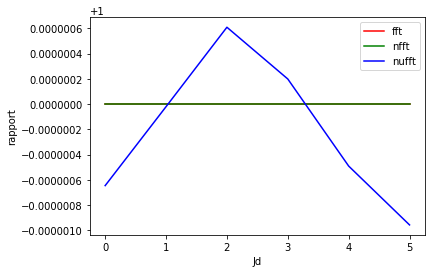

In [6]:
plt.figure()
plt.plot(JJ, np.abs(res_fft), color='r', label='fft')
plt.plot(JJ, np.abs(res_nfft), color='g', label='nfft')
plt.plot(JJ, np.abs(res_nufft), color='b', label='nufft')
plt.xlabel('Jd')
plt.ylabel('rapport')
plt.legend()
plt.show()

In [10]:
KK = [64, 128, 256, 512]

res_fft_kernel, res_nfft_kernel, res_nufft_kernel = [], [], []

for Kd in KK:
    res = test_adjoint(_samples, _samples_shift, _kspace, _kspace_gridded, images, Kd, Jd=2)
    res_fft_kernel.append(res['fft'][0]/res['fft'][1])
    res_nfft_kernel.append(res['nfft'][0]/res['nfft'][1])
    res_nufft_kernel.append(res['nufft'][0]/res['nufft'][1])

Creating direct op
Creating the NUFFT object...
Creating adj op
Creating the NUFFT object...
K-space
Recons image
Dot operation
(1.0000000000000415-3.470769953942968e-14j)
(1.0000002520689009-3.6955945983894863e-07j)
(0.999999999999987+6.051685673616039e-14j)
Creating direct op
Creating the NUFFT object...
Creating adj op
Creating the NUFFT object...
K-space
Recons image
Dot operation
(1.0000000000000415-3.470769953942968e-14j)
(7.99999968821621+2.9013921811155874e-07j)
(0.999999999999987+6.051685673616039e-14j)
Creating direct op
Creating the NUFFT object...
Creating adj op
Creating the NUFFT object...
K-space
Recons image
Dot operation
(1.0000000000000415-3.470769953942968e-14j)
(64.00000452533767-7.343796873542175e-06j)
(0.999999999999987+6.051685673616039e-14j)
Creating direct op
Creating the NUFFT object...
Creating adj op
Creating the NUFFT object...
K-space
Recons image


MemoryError: 

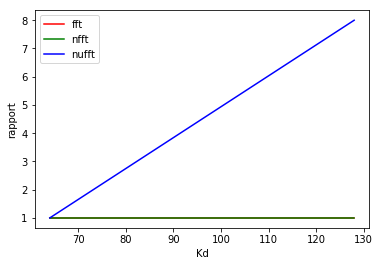

In [9]:
plt.figure()
plt.plot(KK, np.abs(res_fft_kernel), color='r', label='fft')
plt.plot(KK, np.abs(res_nfft_kernel), color='g', label='nfft')
plt.plot(KK, np.abs(res_nufft_kernel), color='b', label='nufft')
plt.xlabel('Kd')
plt.ylabel('rapport')
plt.legend()
plt.show()